In [1]:
import torch
import yaml 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import numpy as np

from model.pl_PairVAE import PlPairVAE
from dataset.datasetPairH5 import PairHDF5Dataset


/home/cdepourt/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Params

In [2]:
path_checkpoint = "/projects/pnria/julien/autofill/runs_pair/grid_ag_wlat0.0001_wsaxs2saxs0.04_wsaxs2les0.05_wles2les0.04_wles2saxs0.05/best.ckpt"
path_config = "/projects/pnria/julien/autofill/runs_pair/grid_ag_wlat0.0001_wsaxs2saxs0.04_wsaxs2les0.05_wles2les0.04_wles2saxs0.05/config_model.yaml"

In [5]:
array_valid = np.load("/projects/pnria/julien/autofill/runs_pair/grid_ag_wlat0.0001_wsaxs2saxs0.04_wsaxs2les0.05_wles2les0.04_wles2saxs0.05/val_indices.npy")
array_valid

array([26477,  4039, 30795, ..., 20875, 15152, 36769])

In [7]:
array_train = np.load("/projects/pnria/julien/autofill/runs_pair/grid_ag_wlat0.0001_wsaxs2saxs0.04_wsaxs2les0.05_wles2les0.04_wles2saxs0.05/train_indices.npy")
array_train

array([ 8373, 13858,  9556, ..., 38300,  9699, 14816])

In [8]:
with open(path_config, 'r') as file:
    config = yaml.safe_load(file)

In [9]:
config

{'dataset': {'conversion_dict_path': '/projects/pnria/caroline/AUTOFILL/conversion_dict_all.json',
  'hdf5_file': '/projects/pnria/caroline/AUTOFILL/pair_saxs_les_closest_of_concentration.h5',
  'metadata_filters': {'material': ['ag']},
  'requested_metadata': ['shape', 'material'],
  'sample_frac': 1.0,
  'transform': {'q_les': {'PaddingTransformer': {'pad_size': 500, 'value': 0}},
   'q_saxs': {'PaddingTransformer': {'pad_size': 500, 'value': 0}},
   'y_les': {'MinMaxNormalizer': {},
    'PaddingTransformer': {'pad_size': 500, 'value': 0}},
   'y_saxs': {'MinMaxNormalizer': {},
    'PaddingTransformer': {'pad_size': 500, 'value': 0}}}},
 'devices': '1',
 'experiment_name': 'grid_ag_wlat0.0001_wsaxs2saxs0.04_wsaxs2les0.05_wles2les0.04_wles2saxs0.05',
 'model': {'VAE_LES': {'args': None,
   'path_checkpoint': '/projects/pnria/julien/autofill/runs/grid_ag_les_beta0.0001_etamin1e-07_ld64_bs64/epoch=73-step=1593590.ckpt',
   'path_config': '/projects/pnria/julien/autofill/runs/grid_ag_les

# Model

In [10]:
model = PlPairVAE(config, load_weights_VAE=False)

INIT VAE SAXS
{'dilation': 1, 'down_channels': [16, 32, 64, 128, 256, 512], 'in_channels': 1, 'input_dim': 500, 'latent_dim': 64, 'output_channels': 1, 'strat': 'y', 'up_channels': [512, 256, 128, 64, 32, 16]}
INIT VAE LES
{'dilation': 1, 'down_channels': [16, 32, 64, 128, 256], 'in_channels': 1, 'input_dim': 500, 'latent_dim': 64, 'output_channels': 1, 'strat': 'y', 'up_channels': [256, 128, 64, 32, 16]}


In [11]:
checkpoint = torch.load(path_checkpoint, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Dataset

In [12]:
dataset = PairHDF5Dataset(
hdf5_file = config["dataset"]["hdf5_file"],
metadata_filters = config["dataset"]["metadata_filters"],
conversion_dict_path = config["dataset"]["conversion_dict_path"],
sample_frac = config["dataset"]["sample_frac"],
transform =  config["dataset"]["transform"],
requested_metadata =  config["dataset"]["requested_metadata"],
)
print("========================================")

Applying filters: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


╒══════════════════════════════════════════════╕
│ Dataset Initialization Info                 │
╞══════════════════════════════════════════════╡
│ File: /projects/pnria/caroline/AUTOFILL/pair_saxs_les_closest_of_concentration.h5 │
│ Total samples: 41841                      │
│ Samples filtered: 41824                   │
│ Requested fraction: 1.0                    │
│ Fractioned samples: 41824                  │
│ Requested metadata: 2                      │


# Plot

In [17]:
def plot(idx_sample):
    one_sample = dataset[idx_sample]
    print(one_sample["metadata"])
    
    one_sample = {k:v.unsqueeze(0) if ("data_" in k and not "min" in k and not "max" in k) else v for k,v in one_sample.items()}
    dict_output = model(one_sample)

    mse_values = {}
    for recon_key in ["recon_les","recon_saxs2les"]:
        mse_values[recon_key] = F.mse_loss(one_sample["data_y_les"], dict_output[recon_key]).item()
    
    for recon_key in ["recon_saxs","recon_les2saxs"]:
        mse_values[recon_key] = F.mse_loss(one_sample["data_y_saxs"], dict_output[recon_key]).item()

    dict_print = dict_output
    dict_print["y_saxs"] = one_sample["data_y_saxs"]
    dict_print["y_les"] = one_sample["data_y_les"]
    dict_print.pop("z_les")
    dict_print.pop("z_saxs")
        
    dict_saxs = {k:v for k,v in dict_print.items() if k.endswith("saxs")}
    dict_les = {k:v for k,v in dict_print.items() if k.endswith("les")}

    plt.figure(figsize=(10, 6))
    for i, (key, tensor) in enumerate(dict_saxs.items(), 1):
        if key != "y_saxs":
            label = f"{key} with MSE : {round(mse_values[key],5)}"
        else :
            label = key
        plt.loglog(tensor.detach().numpy().flatten(), label=label)
        plt.title("SAXS")
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    for i, (key, tensor) in enumerate(dict_les.items(), 1):
        if key != "y_les":
            label = f"{key} with MSE : {round(mse_values[key],5)}"
        else :
            label = key
        plt.plot(tensor.detach().numpy().flatten(), label=label)
        plt.title("LES")
        plt.legend()
    plt.tight_layout()
    plt.show()

## Train

{'shape': tensor(1., dtype=torch.float64), 'material': tensor(2., dtype=torch.float64)}


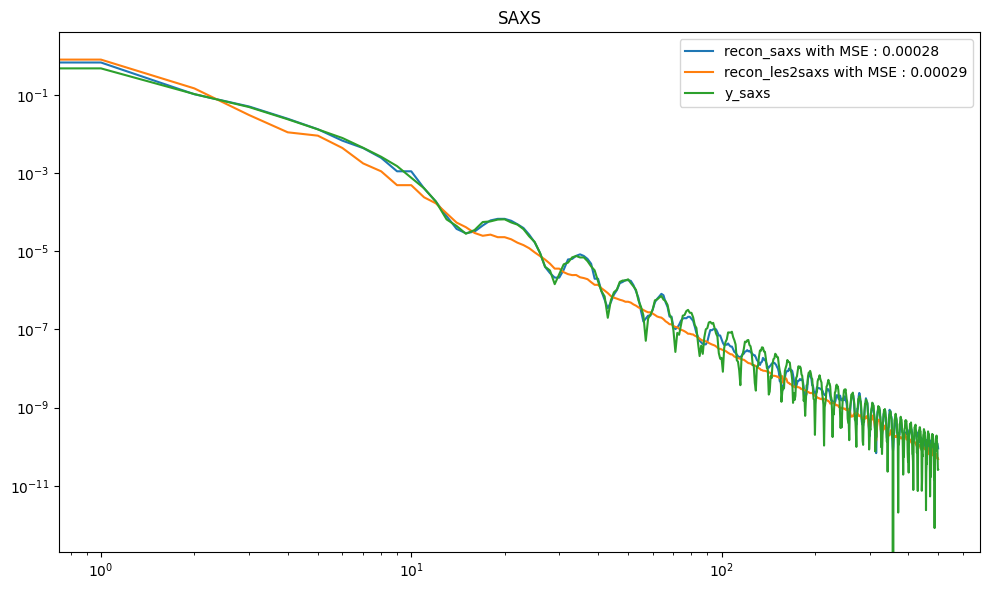

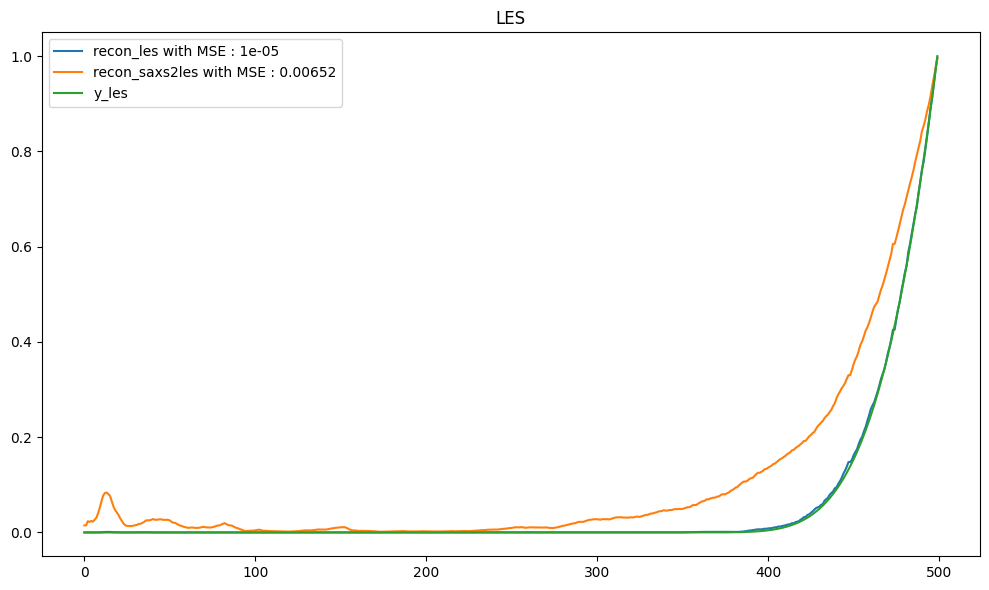

In [18]:
plot(487)

{'shape': tensor(1., dtype=torch.float64), 'material': tensor(2., dtype=torch.float64)}


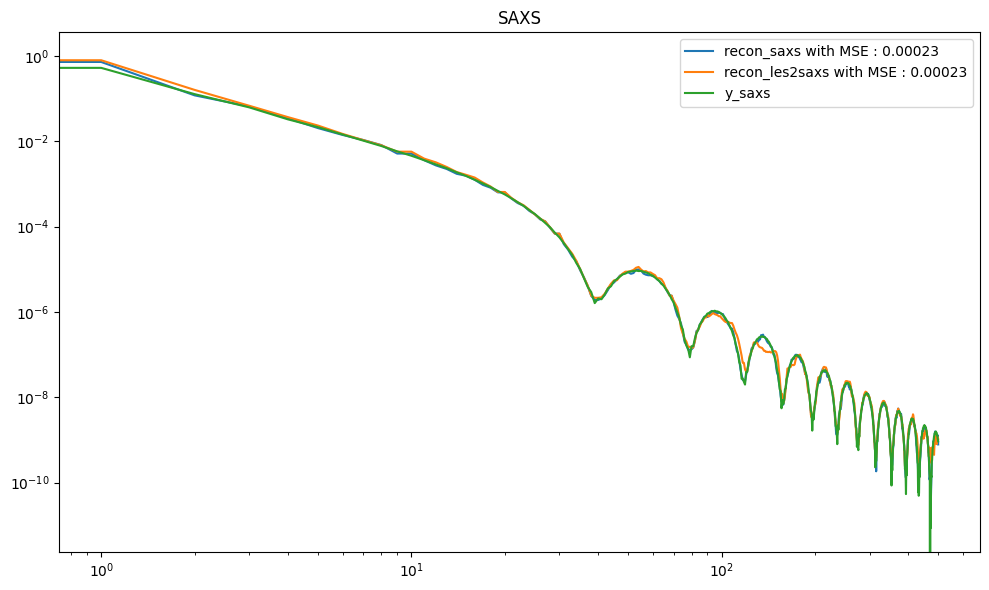

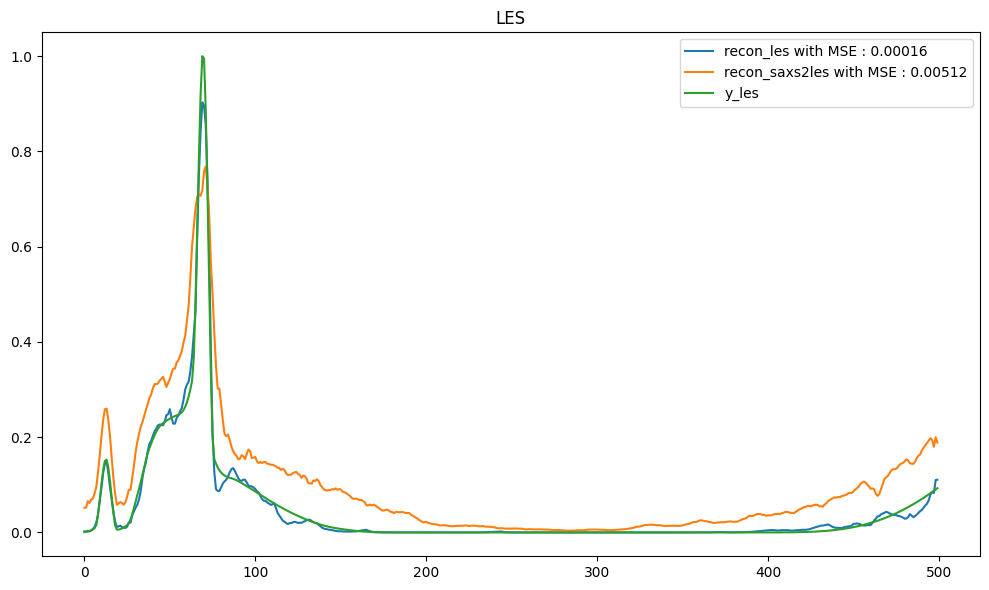

In [19]:
plot(array_train[987])

{'shape': tensor(1., dtype=torch.float64), 'material': tensor(2., dtype=torch.float64)}


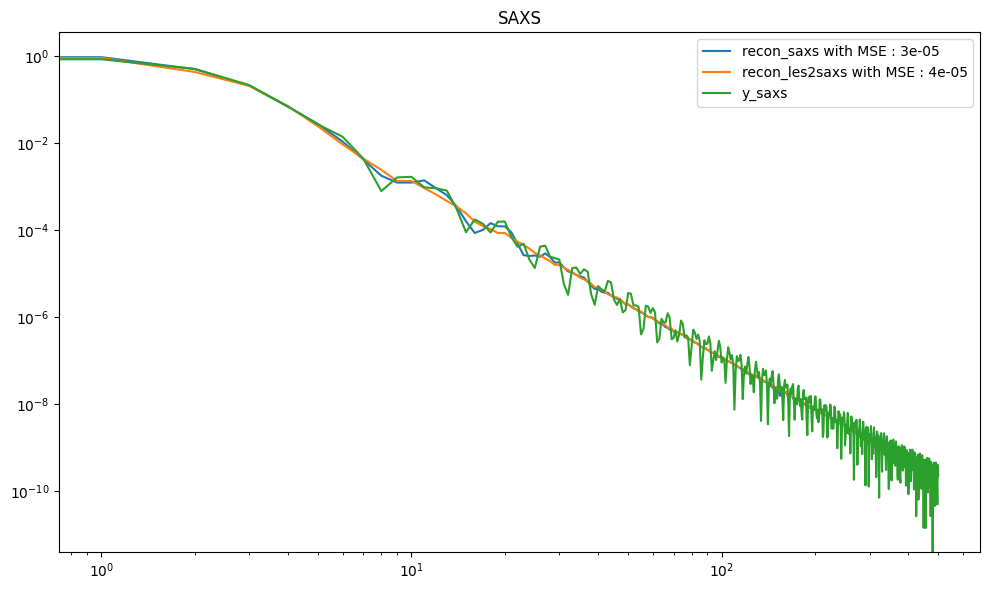

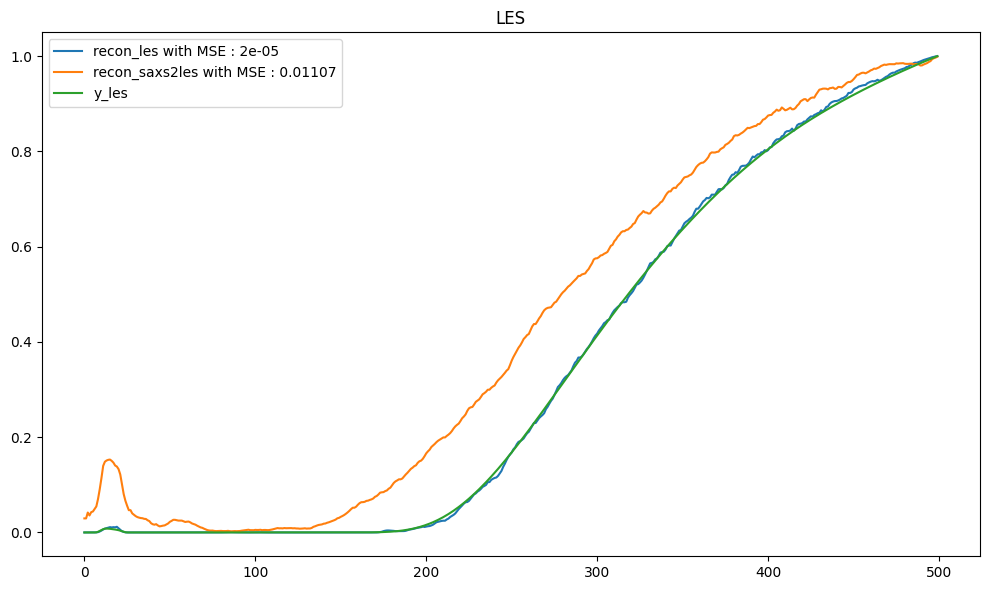

In [20]:
plot(array_train[4944])

## Valid

{'shape': tensor(1., dtype=torch.float64), 'material': tensor(2., dtype=torch.float64)}


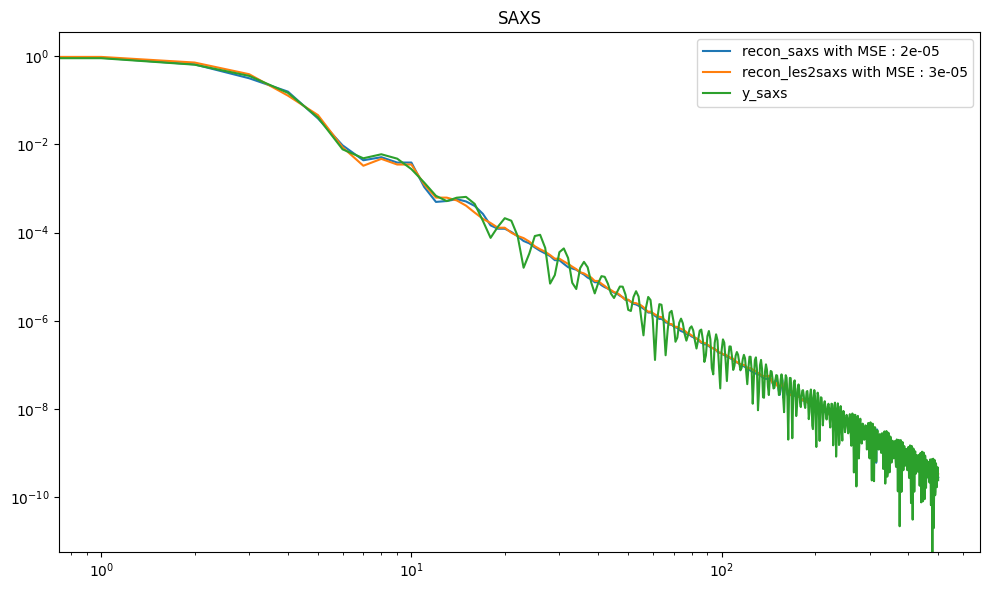

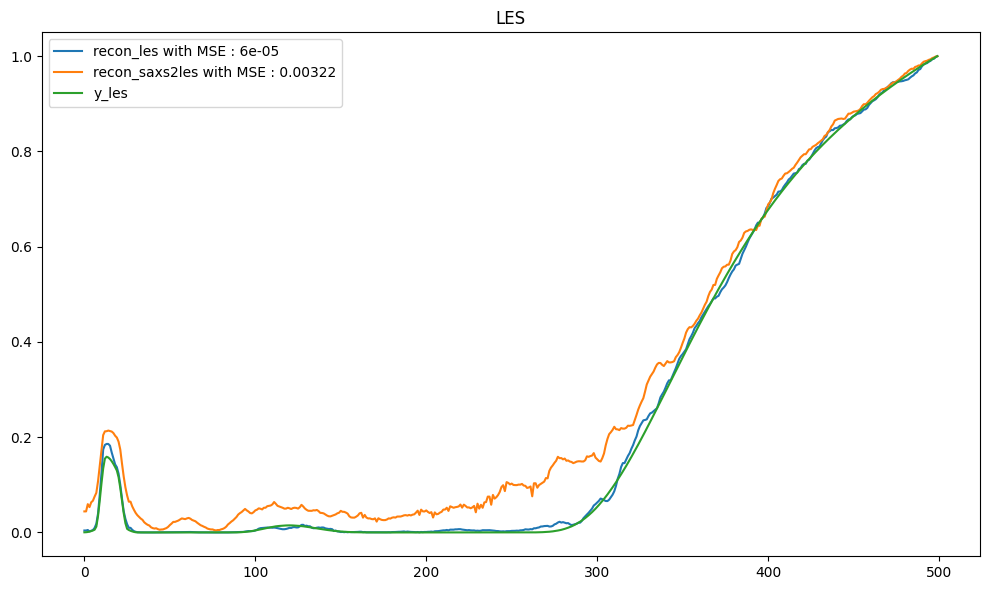

In [21]:
plot(array_valid[8224])

{'shape': tensor(1., dtype=torch.float64), 'material': tensor(2., dtype=torch.float64)}


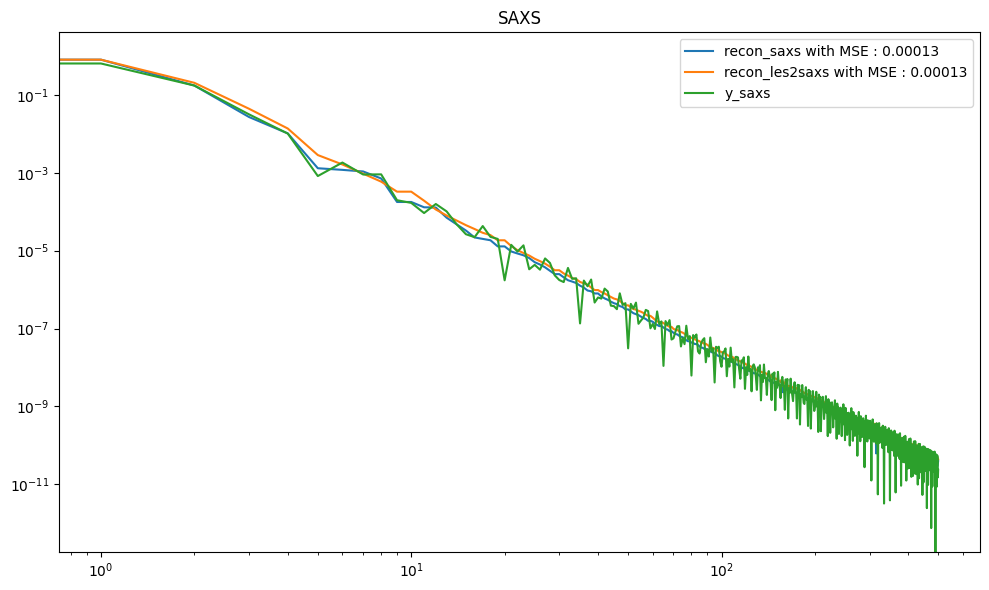

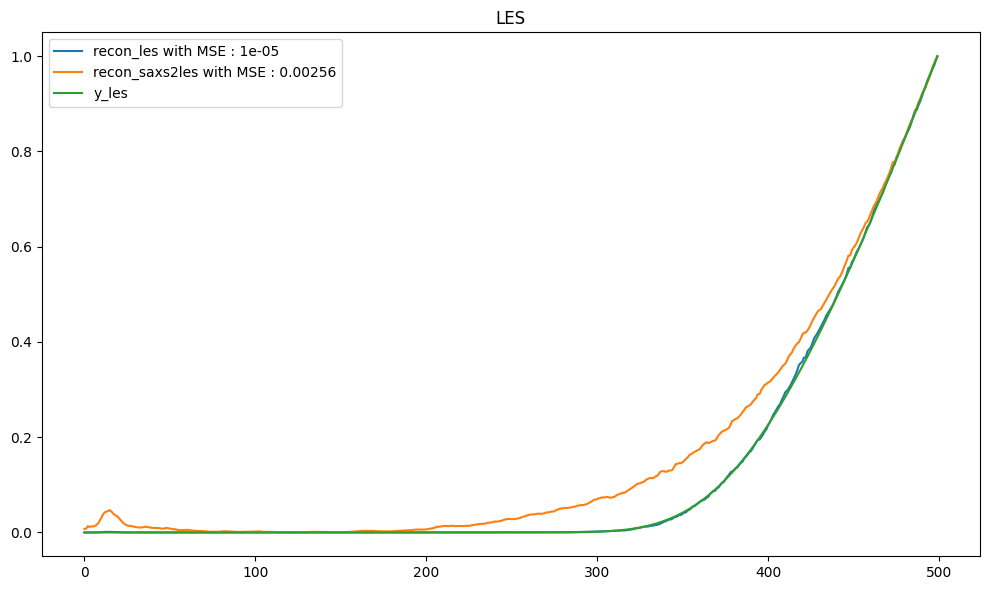

In [22]:
plot(array_valid[45])

{'shape': tensor(1., dtype=torch.float64), 'material': tensor(2., dtype=torch.float64)}


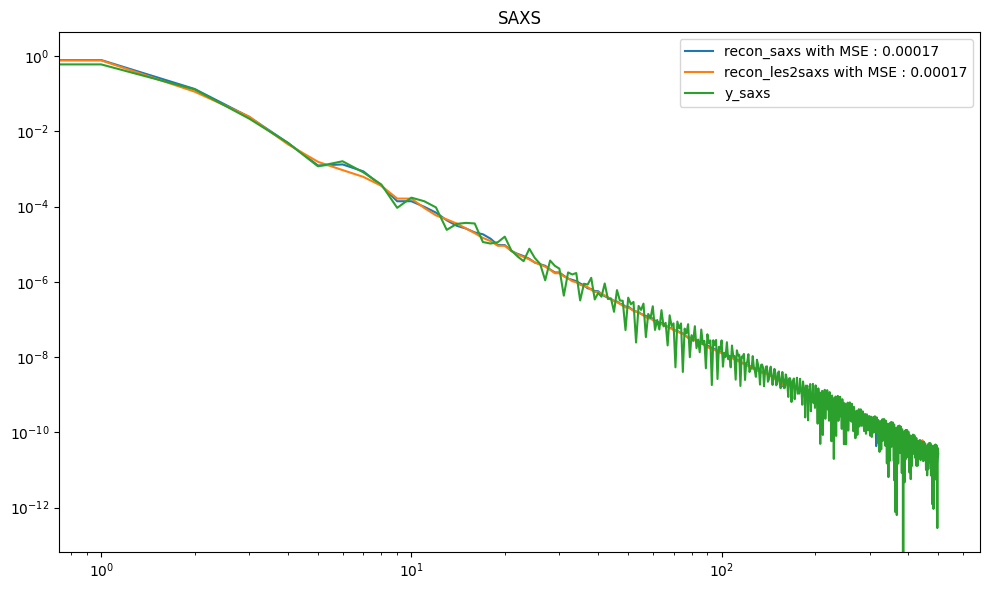

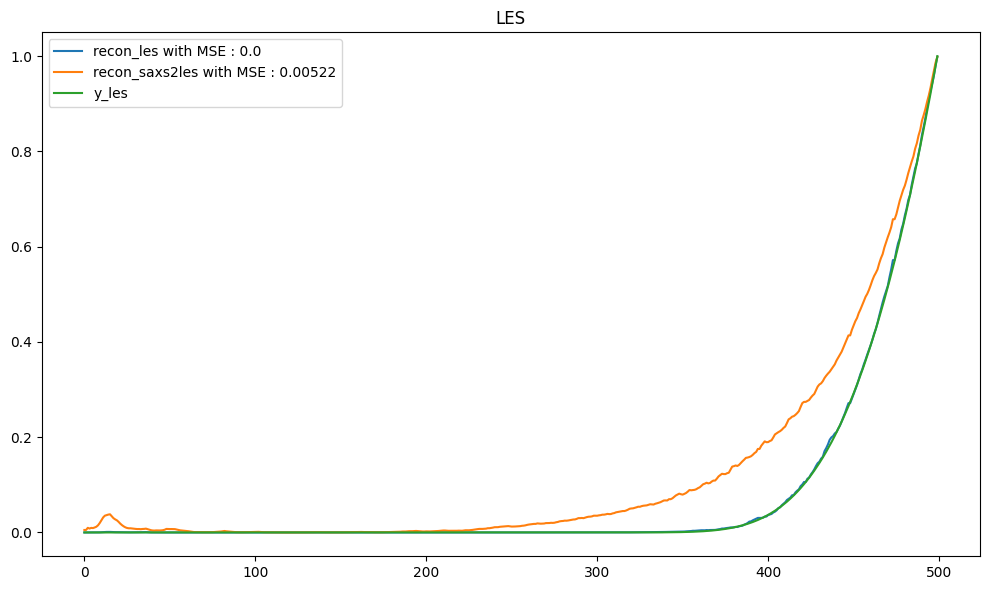

In [23]:
plot(array_valid[111])

{'shape': tensor(1., dtype=torch.float64), 'material': tensor(2., dtype=torch.float64)}


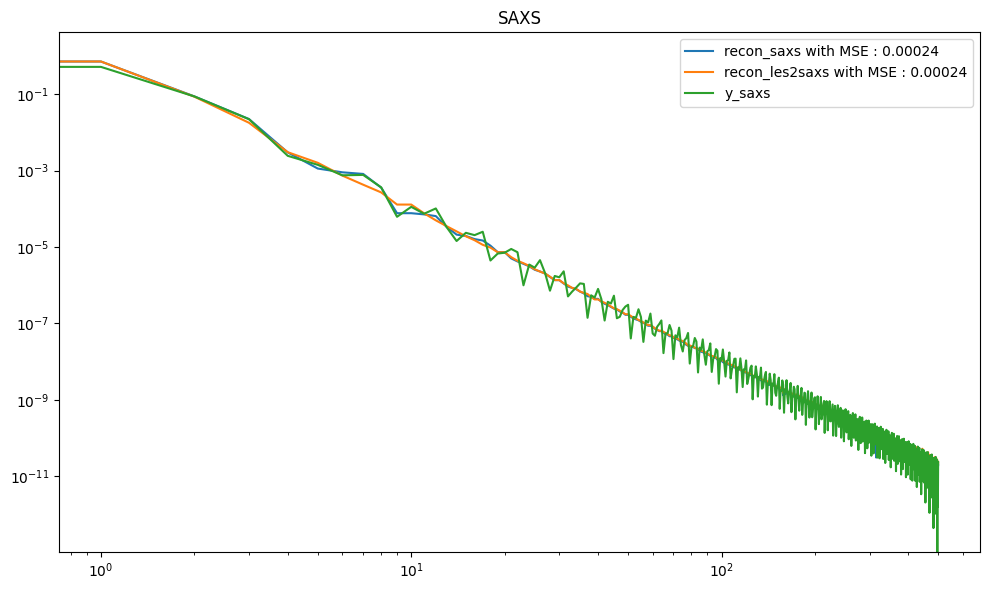

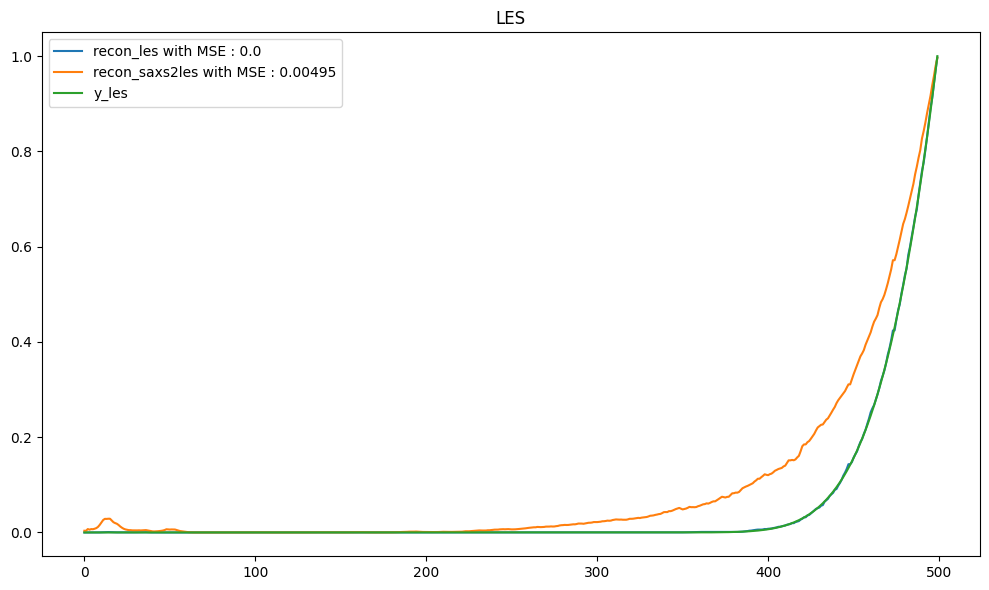

In [24]:
plot(array_valid[32])

{'shape': tensor(1., dtype=torch.float64), 'material': tensor(2., dtype=torch.float64)}


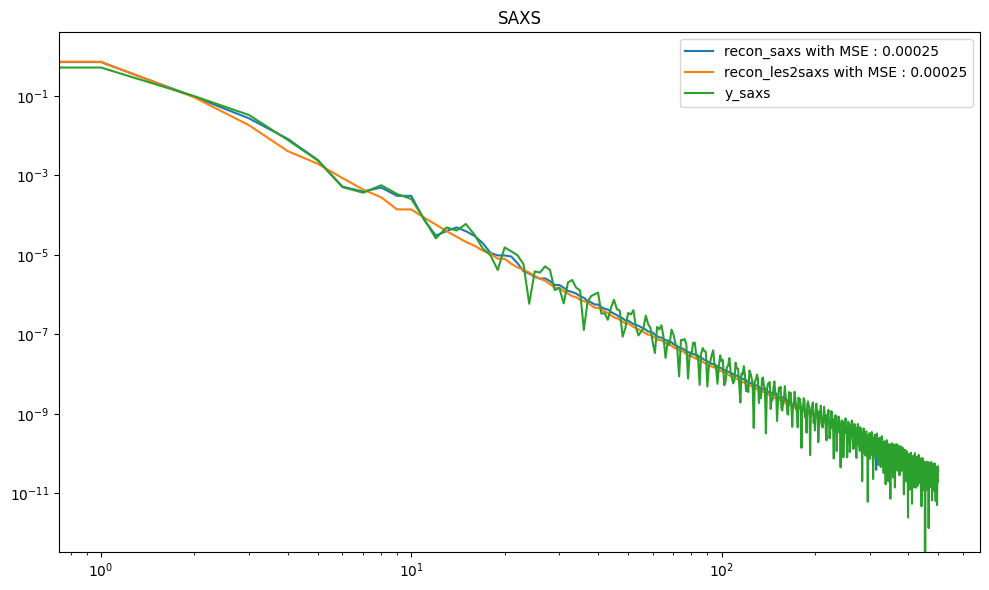

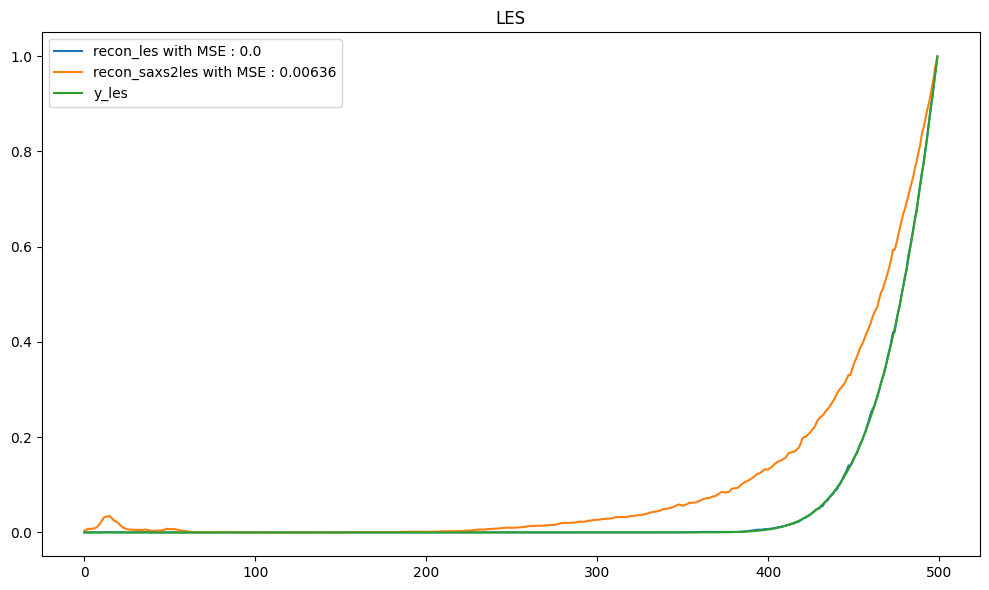

In [25]:
plot(array_valid[1215])